---



# <font color='#ECA702'>**Análisis Multimodal de Síntomas en la Enfermedad de Parkinson**</font>

In [94]:
#@title **Importar librerías**

# Manipulación de datos
import os
import cv2
import numpy as np
import librosa
import pandas as pd
from zipfile import ZipFile

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# Utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import pytz

# sklearn
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [3]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XRruCPRodR4OhRCRZYKsyODqa_GuBkfC/data_parkinson


In [4]:
#@title **Extraer el zip**

os.mkdir('../../../../data')
os.popen('cp data.csv ../../../../data/data.csv')
target_path = os.path.join('../../../../data') # Aquí es donde van a quedar los datos
# deben quedar fuera de drive para poder acceder a ellos 'localmente'

# Unzip the downloaded files
zip_file_path = os.path.join('AudioVisualData_v7.zip')
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_path)

# # Me muevo hasta donde quedaron los datos
%cd ../../../../data
# Verifico
%ls

/content/data
AudioVisualData_v7/  data.csv


## <font color='#4C5FDA'>**Procesamiento del dataset**</font>

### <font color='#52F17F'>**Creación del Dataset Pandas auxiliar**</font>

In [5]:
data = pd.read_csv("data.csv", index_col='patient')

def string2array(string: str):
  """ Convierte un string con datos a numpy array """
  string = string.strip('[]')
  return np.fromstring(string, sep=',')

data['flatten_log_mel_spectogram'] = data['flatten_log_mel_spectogram'].apply(string2array)
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram
patient,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26...."


### <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

In [6]:
"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

In [7]:
class PatientDataset(Dataset):
  def __init__(self, dataframe, n_frames = FRAMES_PROMEDIO):
    self.dataframe = dataframe
    # self.transform = transform
    self.n_frames = n_frames
    # self.audios = sorted(os.listdir(audio_dir)) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos el audio de la lista
    # audio_path = os.path.join(self.audio_dir, self.audios[index])
    # audio_path = os.path.join(self.dataframe['audio_path'][index])

    # Leemos el audio
    audio = self.dataframe['flatten_log_mel_spectogram'][index].astype(np.float32)
    audio = audio.reshape((90, 10))
    audio = torch.from_numpy(audio).unsqueeze(0)

    """ Carga de los frames """

    # Entramos a la carpeta y conseguimos los frames de la lista.
      # La razon por la que uso la misma lista de audios es porque el audio y el vídeo
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ audios: AudioVisualData_v7/Control/C0/Phonemes/audio/C0-1-Pakata.mp3 """
    """ vídeo: AudioVisualData_v7/Control/C0/Phonemes/frames/C0-1-Pakata.mov """
    video_path = os.path.join(self.dataframe['frames_path'][index])
    # video_path = os.path.join(self.video_dir, self.audios[index].replace(".mp3", ".mov"))

    frames_path = sorted(os.listdir(video_path))[:self.n_frames]
    frames = []
    for frame in frames_path:
      frame_path = os.path.join(self.dataframe['frames_path'][index], frame)
      # print(frame_path)
      frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
      frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
      frame = frame / 255. # Normalizamos entre 0 y 1
      frames.append(frame)

    frames = np.expand_dims(np.stack(frames), axis=1).astype('float32')
    frames = frames.transpose(1, 0, 2, 3)
    frames = torch.from_numpy(frames)

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'Parkinson' 1
    # sino 0.

    label = 1 if 'Parkinson' in self.dataframe['audio_path'][index] else 0

    return audio, frames, label

In [8]:
complete_dataset = PatientDataset(data)
print(complete_dataset.__len__())
print(complete_dataset[0][0].shape, complete_dataset[0][1].shape , complete_dataset[0][2])

1091
torch.Size([1, 90, 10]) torch.Size([1, 14, 112, 112]) 0


### <font color='#52F17F'>**Visualización de los datos**</font>

In [ ]:
def plot_frame_strip(frames, rows=2, cols=7):
    """
    Hace un plot de la tira de frames en una matriz de imágenes.

    Args:
        frames (np.ndarray): Tensor de frames con forma (num_frames, height, width, channels).
        rows (int): Número de filas en la tira de frames.
        cols (int): Número de columnas en la tira de frames.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(20, 6))

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(frames):
                axes[i, j].imshow(frames[idx], cmap='gray')
                axes[i, j].axis('off')
                axes[i, j].set_title(f"Frame: {idx}")
    plt.show()

In [ ]:
plot_frame_strip(complete_dataset[0][1].squeeze(0).numpy())

In [ ]:
complete_dataset[0][0].squeeze(0).numpy().reshape((90, 10)).shape

(90, 10)

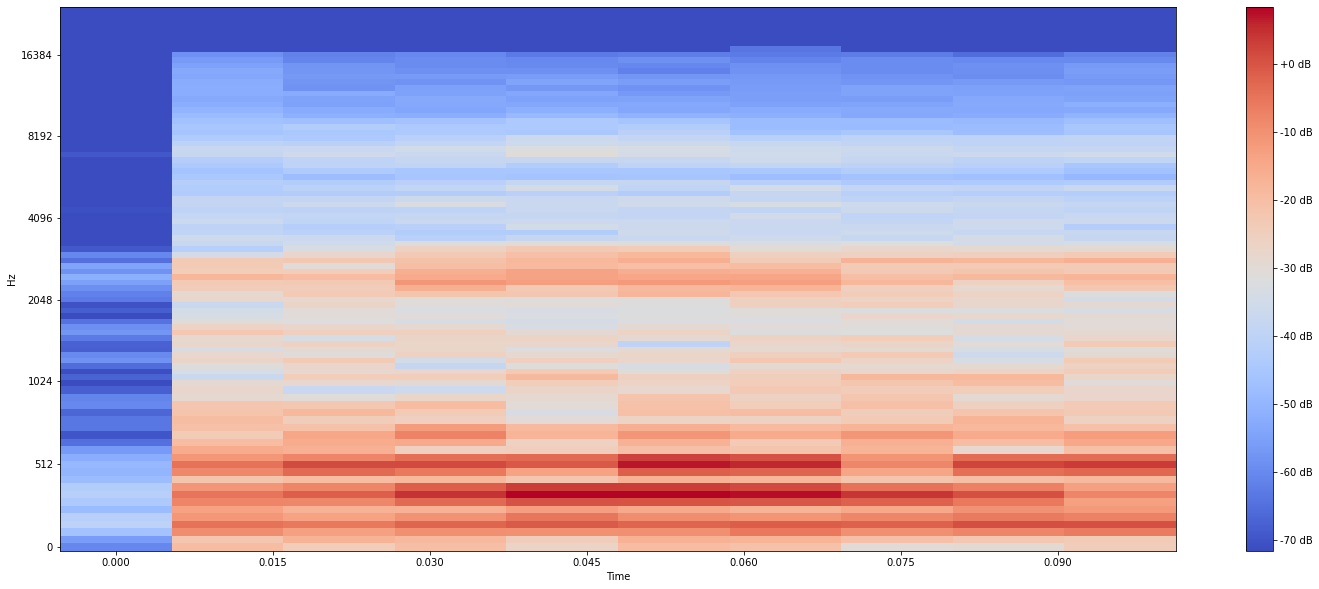

In [ ]:
plt.figure(figsize=(25,10))
librosa.display.specshow(complete_dataset[0][0].squeeze(0).numpy(), y_axis='mel', x_axis='time', sr=48000)
plt.colorbar(format="%+2.f dB")
plt.show()

### <font color='#52F17F'>**Partición de los datos**</font>

In [9]:
# Extraer los datos para GroupKFold https://discuss.pytorch.org/t/custom-datatype-for-many-images-to-one-label/87629
X = [i for i in range(len(data))]
y = data['label'].values
groups = data.index.values

In [10]:
groupk_folds = 7
gkf = GroupKFold(n_splits=groupk_folds)
# Realizar la validación cruzada por grupos
for i, (train_index, test_index) in enumerate(gkf.split(X, y, groups), 1):
    train_groups = groups[train_index]
    test_groups = groups[test_index]

    print(f"División {i}:")
    print("  Pacientes en entrenamiento:", np.unique(train_groups))
    print("  Pacientes en prueba:", np.unique(test_groups))
    print("  Número de pacientes en entrenamiento:", len(np.unique(train_groups)))
    print("  Número de pacientes en prueba:", len(np.unique(test_groups)))
    print()

División 1:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C4' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P7']
  Pacientes en prueba: ['C5' 'P8']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 2:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P8']
  Pacientes en prueba: ['C4' 'P7']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 3:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P7' 'P8']
  Pacientes en prueba: ['C3' 'P6']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 4:
  Pacientes en entrenamiento: ['C0' 'C1' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P6' 'P7' 'P8']
  Pacientes en prueba: ['C2' 'P5']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 5:
  Pacientes en entrenamiento: ['C0' 'C2' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P5' 'P6' 'P7' 'P8']
  Pacientes en prueba: [

## <font color='#ECA702'>**Modelo CNN**</font>

### <font color='#52F17F'>**Creando el modelo**</font>

In [83]:
class MultimodalModel(nn.Module):
  def __init__(self, n_channels, n_classes):
    super().__init__()
    # self.audio_model = AudioModule(n_channels, n_classes)
    # self.video_model = VideoModule(n_channels, n_classes)
    self.fc1 = nn.Linear((1 * 14 * 112 * 112) + (1 * 90 * 10), 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, n_classes)  # Suponiendo que es una tarea de clasificación binaria

  def forward(self, audio, video):
    # https://stackoverflow.com/questions/42479902/what-does-view-do-in-pytorch
    audio = audio.view(audio.size(0), -1) # Aplane los audios conservando el batch
    # devuelve: # batch_size x (90*10)

    video = video.view(video.size(0), -1) # Aplane los videos conservando el batch
    # devuelve: # batch_size x (14*112*112)

    combined = torch.cat((video, audio), dim=1) # https://pytorch.org/docs/stable/generated/torch.cat.html
    x = F.relu(self.fc1(combined))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
        # return combined

In [84]:
# Test al modelo, para ver si nos entrega la salida esperada

n_channels = 1
n_classes = 2
input_audio = complete_dataset[0][0].unsqueeze(0)
input_video = complete_dataset[0][1].unsqueeze(0)
print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = MultimodalModel(n_channels=n_channels, n_classes=n_classes)
ouput = model(input_audio, input_video)
print(f"Salida: {ouput.size()}")

Entrada audio: (torch.Size([1, 1, 90, 10]), torch.float32)
Entrada video: (torch.Size([1, 1, 14, 112, 112]), torch.float32)
Salida: torch.Size([1, 2])


In [85]:
# Test al modelo, para ver si nos entrega la salida esperada

n_channels = 1
n_classes = 2
input_video = torch.rand([2, 1, 14, 112, 112])
input_audio = torch.rand([2, 1, 90, 10])

# print(input_audio.view(input_audio.size(0), -1).shape)
# print(input_video.view(input_video.size(0), -1).shape)

# # input_video = complete_dataset[0][1].unsqueeze(0)
print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = MultimodalModel(n_channels=n_channels, n_classes=n_classes)
ouput = model(input_audio, input_video)
print(f"Salida: {ouput.size()}")

Entrada audio: (torch.Size([2, 1, 90, 10]), torch.float32)
Entrada video: (torch.Size([2, 1, 14, 112, 112]), torch.float32)
Salida: torch.Size([2, 2])


### <font color='#52F17F'>**Entrenamiento del modelo**</font>

In [100]:
# Hiperparametros
LEARNING_RATE = 0.1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2

In [101]:
# For fold results

# Acá vamos a guardar las métricas del modelo
results = {
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": []
}

# Storage for plotting
losses_per_epoch = []
accuracies_per_fold = []

# Esto es para guardar los modelos de cada experimento en carpetas separadas
timezone = pytz.timezone('America/Bogota')
timestamp = datetime.now(timezone).strftime('%Y%m%d_%H%M')
exp_path = f'../models/exp_{timestamp}'
os.mkdir(exp_path)

In [111]:
# Storage for plotting
losses_per_epoch = []
accuracies_per_fold = []

In [112]:
# Loop encontrado y modificado de: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
for fold, (train_ids, test_ids) in enumerate(gkf.split(X, y, groups)):

  # Print
  print(f'FOLD {fold+1}')
  print('--------------------------------')

  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.Subset(complete_dataset, train_ids)
  test_subsampler = torch.utils.data.Subset(complete_dataset, test_ids)

  # Define data loaders for training and testing data in this fold
  trainloader = DataLoader(train_subsampler, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
  testloader = DataLoader(test_subsampler, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

  iteraciones = len(trainloader)
  n_prints = int(iteraciones/3)
  # print(int(iteraciones/2))

  """ Parametros del modelo """

  # Creacion del modelo y lo movemos a la GPU o CPU
  model = MultimodalModel(n_channels=1, n_classes=2)
  model.to(DEVICE)

  # Funcion de perdida (loss)
  criterion = nn.CrossEntropyLoss()

  # Algoritmos de optimización del gradiente
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  epoch_number = 0
  EPOCHS = 5

  # Storage for current fold
  losses = []

  for epoch in range(EPOCHS):  # loop over the dataset multiple times
      print(f"EPOCH {epoch_number + 1}")

      running_loss = 0.0
      for i, data in enumerate(tqdm(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        audios, videos, labels = data

        # Movemos los datos al device
        audios = audios.to(DEVICE)
        videos = videos.to(DEVICE)
        labels = labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(audios, videos)
        # print(ouputs.dtype)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % n_prints == n_prints-1:    # print every 100 mini-batches
            print(f'batch {i + 1:5d} loss: {running_loss / (i + 1):.3f}')
            # Store loss per epoch
            # running_loss = 0.0
      losses.append(np.round(running_loss / (i+1), 3))
      epoch_number += 1 # Pasamos a la siguiente época

  # Store losses for current fold
  losses_per_epoch.append(losses)

  # Process is complete.
  print('Training process has finished. Saving trained model.')

#   # Print about testing
#   print('Starting testing')

#   # Saving the model
#   # Crear la carpeta models por si no existe
#   if os.path.exists('../models') == False:
#     os.mkdir("../models")
#   save_path = f'{exp_path}/model-fold-{fold}.pth'
#   torch.save(model.state_dict(), save_path)

#   # Evaluation for this fold
#   y_true = []
#   y_pred = []
#   with torch.no_grad():
#       # Iterate over the test data and generate predictions
#       for i, data in enumerate(testloader, 0):
#           # Get inputs
#           audios, videos, labels = data

#           # Movemos los datos al device
#           audios = audios.to(DEVICE)
#           videos = videos.to(DEVICE)
#           labels = labels.to(DEVICE)

#           # Generate outputs
#           outputs = model(audios, videos)
#           _, predicted = torch.max(outputs.data, 1)

#           y_true.extend(labels.cpu().numpy())
#           y_pred.extend(predicted.cpu().numpy())

#   # Calculate metrics
#   accuracy = accuracy_score(y_true, y_pred)
#   recall = recall_score(y_true, y_pred, average='binary')
#   precision = precision_score(y_true, y_pred, average='binary')
#   f1 = f1_score(y_true, y_pred, average='binary')

#   # Print metrics
#   print(f'Accuracy for fold {fold+1}: {accuracy * 100:.2f} %')
#   print(f'Recall for fold {fold+1}: {recall:.2f}')
#   print(f'Precision for fold {fold+1}: {precision:.2f}')
#   print(f'F1 Score for fold {fold+1}: {f1:.2f}')
#   print('--------------------------------')

#   results["accuracy"].append(accuracy * 100)
#   accuracies_per_fold.append(accuracy * 100)
#   results["recall"].append(recall)
#   results["precision"].append(precision)
#   results["f1_score"].append(f1)

# # Print fold results
# print(f'GroupK-FOLD CROSS VALIDATION RESULTS FOR {groupk_folds} FOLDS')
# print('--------------------------------')
# for metric, values in results.items():
#     print(f'{metric.capitalize()}:')
#     for fold_idx, value in enumerate(values, 1):
#         print(f'  Fold {fold_idx}: {value:.2f}')
#     print(f'  Average: {np.mean(values):.2f}')

FOLD 1
--------------------------------
EPOCH 1


 33%|███▎      | 77/234 [00:09<00:29,  5.38it/s]

batch    78 loss: 3274.068


 67%|██████▋   | 157/234 [00:21<00:12,  6.22it/s]

batch   156 loss: 0.714


100%|██████████| 234/234 [00:31<00:00,  7.32it/s]


batch   234 loss: 0.704
EPOCH 2


 33%|███▎      | 78/234 [00:08<00:20,  7.50it/s]

batch    78 loss: 0.705


 68%|██████▊   | 158/234 [00:19<00:07,  9.75it/s]

batch   156 loss: 0.702


100%|██████████| 234/234 [00:29<00:00,  7.96it/s]


batch   234 loss: 0.706
EPOCH 3


 34%|███▍      | 79/234 [00:08<00:16,  9.29it/s]

batch    78 loss: 0.703


 67%|██████▋   | 157/234 [00:20<00:08,  9.09it/s]

batch   156 loss: 0.712


100%|██████████| 234/234 [00:28<00:00,  8.21it/s]


batch   234 loss: 0.714
EPOCH 4


 34%|███▍      | 79/234 [00:10<00:16,  9.19it/s]

batch    78 loss: 0.709


 67%|██████▋   | 157/234 [00:23<00:08,  8.99it/s]

batch   156 loss: 0.698


100%|██████████| 234/234 [00:31<00:00,  7.33it/s]


batch   234 loss: 0.701
EPOCH 5


 34%|███▍      | 79/234 [00:11<00:16,  9.26it/s]

batch    78 loss: 0.714


 66%|██████▌   | 155/234 [00:21<00:12,  6.19it/s]

batch   156 loss: 0.709


100%|██████████| 234/234 [00:30<00:00,  7.57it/s]


batch   234 loss: 0.699
Training process has finished. Saving trained model.
FOLD 2
--------------------------------
EPOCH 1


 12%|█▏        | 28/234 [00:03<00:25,  8.00it/s]


KeyboardInterrupt: 

In [117]:
losses_per_epoch

[[3274.068,
  0.714,
  0.704,
  0.705,
  0.702,
  0.706,
  0.703,
  0.712,
  0.714,
  0.709,
  0.698,
  0.701,
  0.714,
  0.709,
  0.699]]

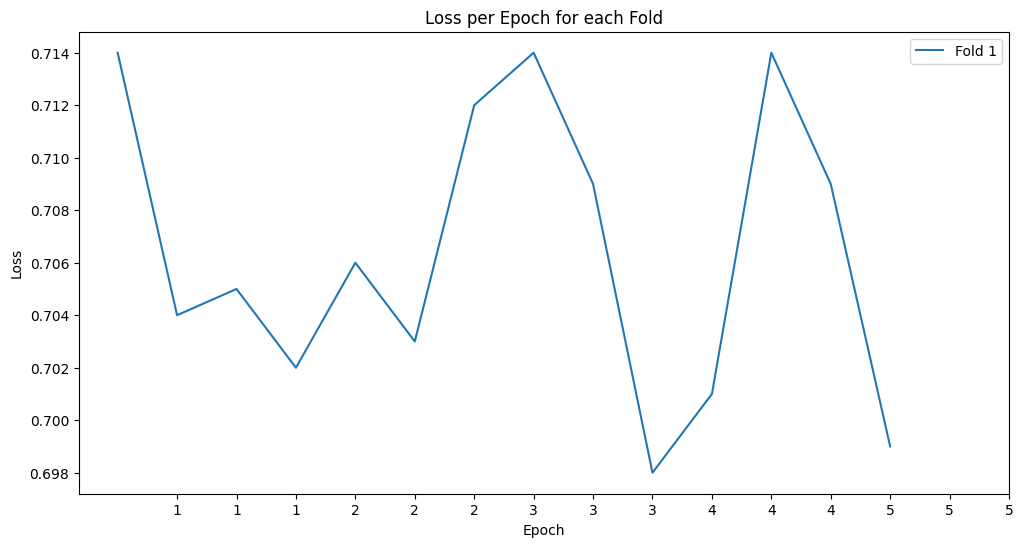

In [119]:
plt.figure(figsize=(12, 6))
for fold_losses in losses_per_epoch:
    plt.plot(fold_losses[1:], label=f'Fold {losses_per_epoch.index(fold_losses) + 1}')

# Ajustar las etiquetas del eje x
# Creamos un array de etiquetas que representen las 5 épocas, espaciando los puntos adecuadamente
x_labels = []
for epoch in range(1, EPOCHS + 1):
    # Añadimos etiquetas en intervalos para que representen las 5 épocas correctamente
    x_labels.extend([epoch] * 3)

plt.xticks(ticks=range(1, len(x_labels) + 1), labels=x_labels)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch for each Fold')
plt.legend()
plt.show()

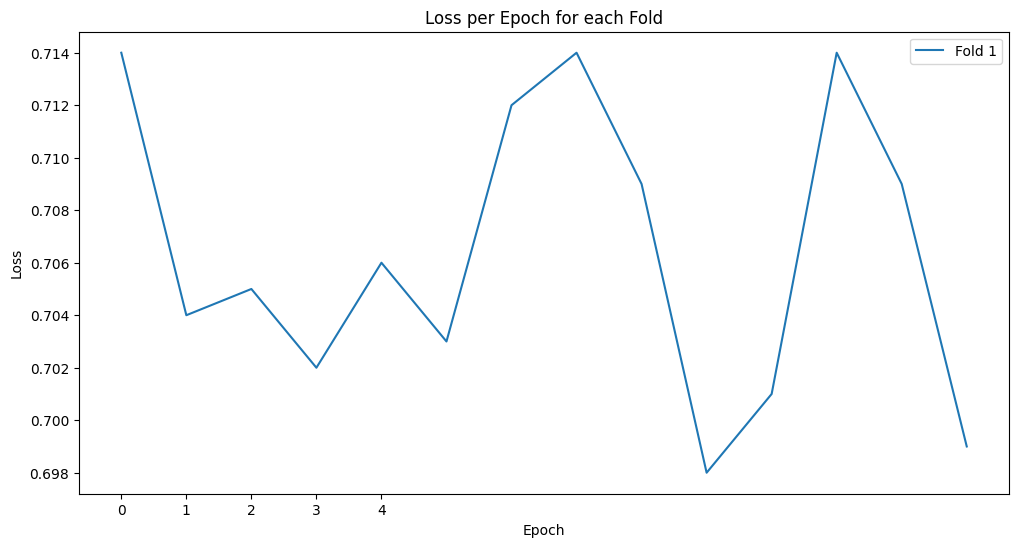

In [118]:
# Plot loss per epoch
plt.figure(figsize=(12, 6))
for fold_losses in losses_per_epoch:
    plt.plot(fold_losses[1:], label=f'Fold {losses_per_epoch.index(fold_losses) + 1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch for each Fold')
plt.legend()
# plt.savefig(f'{exp_path}/figures/a')
plt.xticks([i for i in range(5)])
plt.show()

# Plot accuracy per fold
# plt.figure(figsize=(12, 6))
# plt.plot(range(1, groupk_folds + 1), accuracies_per_fold, marker='o')
# plt.xlabel('Fold')
# plt.ylabel('Accuracy (%)')
# plt.title('Accuracy per Fold')
# # plt.savefig(f'{exp_path}/figures/a')
# plt.show()